In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, precision_score


In [3]:
# Define custom function to print accuracy, precision and recall

def convert_for_sklearn(label_list):
    return [1 if i == 'yes' else 0 for i in label_list]


def accuracy_precision_recall_metrics(y_true, y_pred):
    
    y_test_scoring = convert_for_sklearn(y_true)
    test_pred_scoring = convert_for_sklearn(y_pred)

    acc = accuracy_score(y_true= y_test_scoring, y_pred = test_pred_scoring)
    prec = precision_score(y_true= y_test_scoring, y_pred = test_pred_scoring)
    rec = recall_score(y_true= y_test_scoring, y_pred = test_pred_scoring)
    
    print("Test Precision: ",prec)
    print("Test Recall: ",rec)
    print("Test Accuracy: ",acc)

### Read in the data

In [4]:
dataset_merchant = pd.read_csv("train_merchant_data.csv", na_values='', parse_dates=['Merchant_Registration_Date'])
dataset_order = pd.read_csv("train_order_data.csv", na_values='',  parse_dates=['Date_of_Order'])
dataset_ip = pd.read_csv("train.csv", na_values='')
dataset_ip_boundary = pd.read_csv("ip_boundaries_countries.csv", na_values='')

In [5]:
dataset_merchant.head()

,Ecommerce_Provider_ID,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address
0,1746213,50448,2018-05-01 21:15:11,VATQMMZTVOZUT,F,39,48.151.136.76
1,1746213,338754,2018-04-14 10:13:00,LJCILLBRQZNKS,M,35,94.9.145.169
2,1746213,291127,2018-06-20 07:44:22,JFVHSUGKDAYZV,F,40,58.94.157.121
3,1746213,319919,2018-06-27 01:41:39,WFRXMPLQYXRMY,M,37,193.187.41.186
4,1746213,195911,2018-01-05 00:55:41,GGHKWMSWHCMID,F,27,125.96.20.172


In [6]:
dataset_order.head()

,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method,Merchant_ID
0,126221,37cea9512f8d,2018-04-29 16:39:26,148,Direct,Credit Card,124231
1,115471,09f12e6efde2,2018-06-16 17:05:40,145,SEO,Credit Card,136178
2,151786,4e69e956e159,2018-10-26 18:00:46,62,Ads,Internet Banking,198611
3,140456,663443aaeb82,2018-12-12 05:41:52,28,SEO,Debit Card,127993
4,114721,99258810c121,2018-09-20 11:06:10,70,Ads,Credit Card,250146


In [7]:
dataset_merchant_order =  pd.merge(left= dataset_merchant,right =  dataset_order, how = 'inner', on='Merchant_ID')

In [8]:
dataset_merchant_order.head()

,Ecommerce_Provider_ID,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method
0,1746213,50448,2018-05-01 21:15:11,VATQMMZTVOZUT,F,39,48.151.136.76,129697,3b8983a83c7b,2018-07-30 10:59:13,90,SEO,Debit Card
1,1746213,338754,2018-04-14 10:13:00,LJCILLBRQZNKS,M,35,94.9.145.169,117390,34b5eb921228,2018-06-15 11:19:47,98,SEO,Internet Banking
2,1746213,291127,2018-06-20 07:44:22,JFVHSUGKDAYZV,F,40,58.94.157.121,120162,41a1c86ff08b,2018-08-13 10:06:26,95,SEO,Credit Card
3,1746213,319919,2018-06-27 01:41:39,WFRXMPLQYXRMY,M,37,193.187.41.186,128228,e8c3ad80d916,2018-07-22 15:46:51,100,Direct,E-wallet
4,1746213,195911,2018-01-05 00:55:41,GGHKWMSWHCMID,F,27,125.96.20.172,136029,e71ab1f26785,2018-04-16 08:02:44,78,SEO,E-wallet


In [9]:
dataset_merchant_order.Gender.value_counts()
# dataset_merchant_order.Age_x.value_counts()

M    31761
F    22452
Name: Gender, dtype: int64

In [10]:
dataset_ip

,Merchant_ID,Fraudster
0,221592,0
1,316935,1
2,38454,1
3,214437,1
4,296240,1
...,...,...
54208,243300,0
54209,219957,0
54210,101017,0
54211,50557,0


In [11]:
dataset_merchant_order_fraud = pd.merge(dataset_merchant_order, dataset_ip, on=['Merchant_ID'] )

In [12]:
dataset_merchant_order_fraud

,Ecommerce_Provider_ID,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method,Fraudster
0,1746213,50448,2018-05-01 21:15:11,VATQMMZTVOZUT,F,39,48.151.136.76,129697,3b8983a83c7b,2018-07-30 10:59:13,90,SEO,Debit Card,0
1,1746213,338754,2018-04-14 10:13:00,LJCILLBRQZNKS,M,35,94.9.145.169,117390,34b5eb921228,2018-06-15 11:19:47,98,SEO,Internet Banking,0
2,1746213,291127,2018-06-20 07:44:22,JFVHSUGKDAYZV,F,40,58.94.157.121,120162,41a1c86ff08b,2018-08-13 10:06:26,95,SEO,Credit Card,0
3,1746213,319919,2018-06-27 01:41:39,WFRXMPLQYXRMY,M,37,193.187.41.186,128228,e8c3ad80d916,2018-07-22 15:46:51,100,Direct,E-wallet,0
4,1746213,195911,2018-01-05 00:55:41,GGHKWMSWHCMID,F,27,125.96.20.172,136029,e71ab1f26785,2018-04-16 08:02:44,78,SEO,E-wallet,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54208,1746213,222372,2018-05-01 21:58:19,KGVMENGCIAVOK,M,43,247.25.244.31,111700,58d25819870c,2018-06-12 17:18:37,108,Ads,E-wallet,0
54209,1746213,73491,2018-06-11 19:54:13,QJGPOYDONTYCN,M,41,80.30.170.122,122148,569444812870,2018-09-17 08:49:53,130,Ads,Debit Card,1
54210,1746213,176456,2018-01-06 20:05:55,ZOJNAJMGNRQPZ,F,36,188.39.154.217,125450,902290f02e47,2018-04-10 04:20:07,42,Direct,Debit Card,0
54211,1746213,228277,2018-03-09 07:08:10,MQAOMNZFAHZLS,M,18,116.20.101.178,115567,f465038328e7,2018-06-21 03:35:43,82,Ads,Debit Card,0


### Understand The dataset

In [13]:
dataset_merchant_order_fraud.describe()

,Ecommerce_Provider_ID,Merchant_ID,Age,Customer_ID,Order_Value_USD,Fraudster
count,54213.0,54213.000000,54213.000000,54213.000000,54213.000000,54213.00000
mean,1746213.0,200395.176212,33.122240,137966.285208,92.230240,0.09269
std,0.0,115398.486895,8.630091,15563.516156,45.673263,0.29000
min,1746213.0,2.000000,18.000000,111234.000000,22.000000,0.00000
25%,1746213.0,100997.000000,27.000000,124471.000000,55.000000,0.00000
50%,1746213.0,200574.000000,32.000000,137864.000000,88.000000,0.00000
75%,1746213.0,300407.000000,39.000000,151405.000000,122.000000,0.00000
max,1746213.0,399993.000000,72.000000,165000.000000,385.000000,1.00000


#### Ecommerce ID is redundant so we can remove that column

##### Describe the merged data

In [14]:
# What are the types of data
dataset_merchant_order_fraud.dtypes

Ecommerce_Provider_ID                  int64
Merchant_ID                            int64
Merchant_Registration_Date    datetime64[ns]
Registered_Device_ID                  object
Gender                                object
Age                                    int64
IP_Address                            object
Customer_ID                            int64
Order_ID                              object
Date_of_Order                 datetime64[ns]
Order_Value_USD                        int64
Order_Source                          object
Order_Payment_Method                  object
Fraudster                              int64
dtype: object

In [15]:
# What is the distribution of numerical columns?
dataset_merchant_order_fraud.describe()
# Ecommerce_Provider_ID is same throughout , we can remove them

,Ecommerce_Provider_ID,Merchant_ID,Age,Customer_ID,Order_Value_USD,Fraudster
count,54213.0,54213.000000,54213.000000,54213.000000,54213.000000,54213.00000
mean,1746213.0,200395.176212,33.122240,137966.285208,92.230240,0.09269
std,0.0,115398.486895,8.630091,15563.516156,45.673263,0.29000
min,1746213.0,2.000000,18.000000,111234.000000,22.000000,0.00000
25%,1746213.0,100997.000000,27.000000,124471.000000,55.000000,0.00000
50%,1746213.0,200574.000000,32.000000,137864.000000,88.000000,0.00000
75%,1746213.0,300407.000000,39.000000,151405.000000,122.000000,0.00000
max,1746213.0,399993.000000,72.000000,165000.000000,385.000000,1.00000


In [16]:
dataset_merchant_order_fraud = dataset_merchant_order_fraud.drop(['Ecommerce_Provider_ID'], axis = 1)

In [17]:
# What is the distribution of numerical columns?
dataset_merchant_order_fraud.describe(include=['object'])

,Registered_Device_ID,Gender,IP_Address,Order_ID,Order_Source,Order_Payment_Method
count,54213,54213,54213,54213,54213,54213
unique,51291,2,52028,54213,3,5
top,USYRYIUTYSOKD,M,107.29.25.29,90cd1b5b780f,SEO,Credit Card
freq,9,31761,9,1,21884,21844


In [18]:
dataset_merchant_order_fraud.Fraudster.value_counts()

0    49188
1     5025
Name: Fraudster, dtype: int64

### Plot showing the percentage of people who have committed fraud

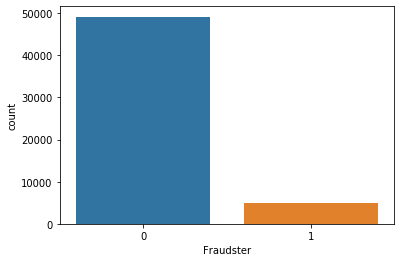

0    49188
1     5025
Name: Fraudster, dtype: int64
Percentage of people who have committed: 9.268994521609208 %


In [19]:
sns.countplot(x='Fraudster',data=dataset_merchant_order_fraud)
plt.show()

# What are the counts?
print(dataset_merchant_order_fraud.Fraudster.value_counts())

# What is the percentage of frauds?
count_yes = len(dataset_merchant_order_fraud[dataset_merchant_order_fraud.Fraudster == 1])
count_no = len(dataset_merchant_order_fraud[dataset_merchant_order_fraud.Fraudster == 0])

percent_success = (count_yes/(count_yes + count_no))*100

print('Percentage of people who have committed:', percent_success, "%")

In [20]:
dataset_merchant_order_fraud.head()

,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method,Fraudster
0,50448,2018-05-01 21:15:11,VATQMMZTVOZUT,F,39,48.151.136.76,129697,3b8983a83c7b,2018-07-30 10:59:13,90,SEO,Debit Card,0
1,338754,2018-04-14 10:13:00,LJCILLBRQZNKS,M,35,94.9.145.169,117390,34b5eb921228,2018-06-15 11:19:47,98,SEO,Internet Banking,0
2,291127,2018-06-20 07:44:22,JFVHSUGKDAYZV,F,40,58.94.157.121,120162,41a1c86ff08b,2018-08-13 10:06:26,95,SEO,Credit Card,0
3,319919,2018-06-27 01:41:39,WFRXMPLQYXRMY,M,37,193.187.41.186,128228,e8c3ad80d916,2018-07-22 15:46:51,100,Direct,E-wallet,0
4,195911,2018-01-05 00:55:41,GGHKWMSWHCMID,F,27,125.96.20.172,136029,e71ab1f26785,2018-04-16 08:02:44,78,SEO,E-wallet,0


### Distribution of Other Variables

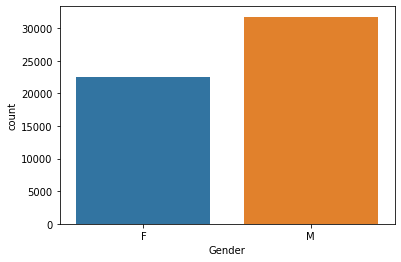

M    31761
F    22452
Name: Gender, dtype: int64


In [21]:
sns.countplot(x='Gender',data=dataset_merchant_order_fraud)
plt.show()

# What are the counts?
print(dataset_merchant_order_fraud.Gender.value_counts())

# What is the percentage?
count_yes = len(dataset_merchant_order_fraud[dataset_merchant_order_fraud.Gender == 'M'])
count_no = len(dataset_merchant_order_fraud[dataset_merchant_order_fraud.Gender == 'F'])


# The propotion of female population is 41.41%

In [22]:
dataset_merchant_order_fraud.isnull().sum()
# No Missing Values

Merchant_ID                   0
Merchant_Registration_Date    0
Registered_Device_ID          0
Gender                        0
Age                           0
IP_Address                    0
Customer_ID                   0
Order_ID                      0
Date_of_Order                 0
Order_Value_USD               0
Order_Source                  0
Order_Payment_Method          0
Fraudster                     0
dtype: int64

In [23]:
dataset_merchant_order_fraud[dataset_merchant_order_fraud.Fraudster == 1].Gender.value_counts()
# Males are more prone to committing frauds.

M    2990
F    2035
Name: Gender, dtype: int64

In [24]:
dataset_merchant_order_fraud.Order_Source.value_counts()
# Order Source has 3 categories SEO, Ads, Direct

SEO       21884
Ads       21259
Direct    11070
Name: Order_Source, dtype: int64

In [25]:
dataset_merchant_order_fraud.dtypes

Merchant_ID                            int64
Merchant_Registration_Date    datetime64[ns]
Registered_Device_ID                  object
Gender                                object
Age                                    int64
IP_Address                            object
Customer_ID                            int64
Order_ID                              object
Date_of_Order                 datetime64[ns]
Order_Value_USD                        int64
Order_Source                          object
Order_Payment_Method                  object
Fraudster                              int64
dtype: object

In [26]:
dataset_merchant_order_fraud.IP_Address.value_counts()

107.29.25.29       9
115.241.135.193    9
137.29.157.65      9
136.189.191.154    9
107.136.93.76      9
                  ..
216.89.236.247     1
143.215.143.7      1
205.254.227.219    1
99.89.130.61       1
38.82.117.36       1
Name: IP_Address, Length: 52028, dtype: int64

In [27]:
dataset_merchant_order_fraud.groupby('IP_Address').count()

,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method,Fraudster
IP_Address,,,,,,,,,,,,
0.0.203.125,1,1,1,1,1,1,1,1,1,1,1,1
0.10.42.221,1,1,1,1,1,1,1,1,1,1,1,1
0.102.175.212,1,1,1,1,1,1,1,1,1,1,1,1
0.107.121.164,1,1,1,1,1,1,1,1,1,1,1,1
0.107.163.16,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
99.93.176.110,1,1,1,1,1,1,1,1,1,1,1,1
99.94.29.215,1,1,1,1,1,1,1,1,1,1,1,1
99.94.53.153,1,1,1,1,1,1,1,1,1,1,1,1


In [28]:
dataset_merchant_order_fraud.IP_Address.nunique()

52028

In [29]:
dataset_merchant_order_fraud.dtypes

Merchant_ID                            int64
Merchant_Registration_Date    datetime64[ns]
Registered_Device_ID                  object
Gender                                object
Age                                    int64
IP_Address                            object
Customer_ID                            int64
Order_ID                              object
Date_of_Order                 datetime64[ns]
Order_Value_USD                        int64
Order_Source                          object
Order_Payment_Method                  object
Fraudster                              int64
dtype: object

### Analysing IP_Boundaries_Countries

In [30]:
dataset_ip_boundary.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,1.0.0.0,1.0.0.255,Australia
1,1.0.1.0,1.0.1.255,China
2,1.0.2.0,1.0.3.255,China
3,1.0.4.0,1.0.7.255,Australia
4,1.0.8.0,1.0.15.255,China


In [31]:
dm = dataset_ip_boundary.copy()

In [32]:
dm.groupby('lower_bound_ip_address').nunique()

,lower_bound_ip_address,upper_bound_ip_address,country
lower_bound_ip_address,,,
1.0.0.0,1,1,1
1.0.1.0,1,1,1
1.0.128.0,1,1,1
1.0.16.0,1,1,1
1.0.2.0,1,1,1
...,...,...,...
99.198.96.0,1,1,1
99.199.0.0,1,1,1
99.200.0.0,1,1,1


## Feature Engineering

#### Here we have Date of Order and Merchant Registration Date as date . We can split date into Year, month, Day , week category 

In [33]:
dataset_merchant_order_fraud["hr"] = dataset_merchant_order_fraud["Date_of_Order"].dt.hour
dataset_merchant_order_fraud["weekday"] = dataset_merchant_order_fraud["Date_of_Order"].dt.weekday
dataset_merchant_order_fraud["dayofyear"] = dataset_merchant_order_fraud["Date_of_Order"].dt.dayofyear
dataset_merchant_order_fraud["month"] = dataset_merchant_order_fraud["Date_of_Order"].dt.month
dataset_merchant_order_fraud["year"] = dataset_merchant_order_fraud["Date_of_Order"].dt.year

In [34]:
dataset_merchant_order_fraud["hr_merchant"] = dataset_merchant_order_fraud["Merchant_Registration_Date"].dt.hour
dataset_merchant_order_fraud["weekday_merchant"] = dataset_merchant_order_fraud["Merchant_Registration_Date"].dt.weekday
dataset_merchant_order_fraud["dayofyear_merchant"] = dataset_merchant_order_fraud["Merchant_Registration_Date"].dt.dayofyear
dataset_merchant_order_fraud["month_merchant"] = dataset_merchant_order_fraud["Merchant_Registration_Date"].dt.month
dataset_merchant_order_fraud["year_merchant"] = dataset_merchant_order_fraud["Merchant_Registration_Date"].dt.year

In [35]:
dataset_merchant_order_fraud.head()

,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,...,hr,weekday,dayofyear,month,year,hr_merchant,weekday_merchant,dayofyear_merchant,month_merchant,year_merchant
0,50448,2018-05-01 21:15:11,VATQMMZTVOZUT,F,39,48.151.136.76,129697,3b8983a83c7b,2018-07-30 10:59:13,90,...,10,0,211,7,2018,21,1,121,5,2018
1,338754,2018-04-14 10:13:00,LJCILLBRQZNKS,M,35,94.9.145.169,117390,34b5eb921228,2018-06-15 11:19:47,98,...,11,4,166,6,2018,10,5,104,4,2018
2,291127,2018-06-20 07:44:22,JFVHSUGKDAYZV,F,40,58.94.157.121,120162,41a1c86ff08b,2018-08-13 10:06:26,95,...,10,0,225,8,2018,7,2,171,6,2018
3,319919,2018-06-27 01:41:39,WFRXMPLQYXRMY,M,37,193.187.41.186,128228,e8c3ad80d916,2018-07-22 15:46:51,100,...,15,6,203,7,2018,1,2,178,6,2018
4,195911,2018-01-05 00:55:41,GGHKWMSWHCMID,F,27,125.96.20.172,136029,e71ab1f26785,2018-04-16 08:02:44,78,...,8,0,106,4,2018,0,4,5,1,2018


### Assigning country based on IP Address

In [36]:
os.getcwd()

'/Users/indrajitv/Desktop/hackathon'

In [37]:
# ip_data=data["IP_Address"]
# k=[]
# for i in range(len(ip_data)):
#     ip=ip_data[i]
#     tmp=ip_diff[(ip_diff['lower_bound_ip_address']<=ip) & (ip_diff['upper_bound_ip_address']>=ip)]
#     tmp=tmp['country'].tolist()
#     k.append(tmp)
# data['country']=k

In [38]:
country_data = pd.read_csv("best_data.csv")

In [39]:
country_data["country"].value_counts()

United States     16841
unknown           15113
China              4022
Japan              2883
United Kingdom     1603
                  ...  
Ghana                 1
Greenland             1
Guam                  1
Iraq                  1
Mauritius             1
Name: country, Length: 128, dtype: int64

In [40]:
country = pd.DataFrame()

In [41]:
country["country"] = country_data['country']

In [42]:
country_data["country"]

0         United States
1                 Italy
2                 Japan
3               Germany
4                 China
              ...      
54208           unknown
54209    United Kingdom
54210    United Kingdom
54211             China
54212          Thailand
Name: country, Length: 54213, dtype: object

In [43]:
country["country"].isnull().sum()

0

### Visualization

In [43]:
import seaborn as sns


In [45]:
values = dataset_merchant_order_fraud.drop(['Merchant_Registration_Date', 'Date_of_Order'], axis = 1)

In [48]:
sns.pairplot(values, hue = 'Fraudster')

### From the graphs shown above , we can see that the blue datapoints are overlapping the orange datapoints. This means that simple Logistic Regression line won't be the best model to seperate fraud from non-fraud. Hence we use  Decision Trees , SVM, Gradient Boost to test the model

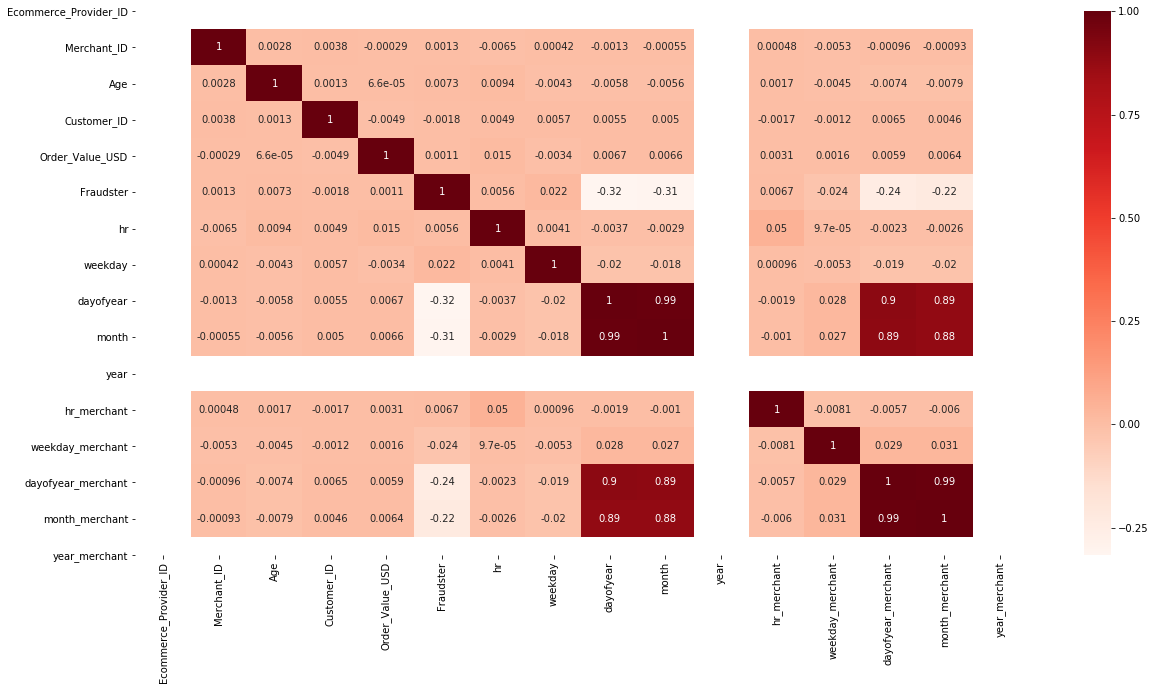

In [258]:
plt.figure(figsize=(20,10))
cor = dataset_merchant_order_fraud.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### Day of the year merchant and Day of the year orders are highly correlated

#### Merging country with dataframe

In [44]:
dataset_merchant_order_fraud = pd.concat([dataset_merchant_order_fraud, country], axis = 1)

In [45]:
dataset_merchant_order_fraud.head()

,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,...,weekday,dayofyear,month,year,hr_merchant,weekday_merchant,dayofyear_merchant,month_merchant,year_merchant,country
0,50448,2018-05-01 21:15:11,VATQMMZTVOZUT,F,39,48.151.136.76,129697,3b8983a83c7b,2018-07-30 10:59:13,90,...,0,211,7,2018,21,1,121,5,2018,United States
1,338754,2018-04-14 10:13:00,LJCILLBRQZNKS,M,35,94.9.145.169,117390,34b5eb921228,2018-06-15 11:19:47,98,...,4,166,6,2018,10,5,104,4,2018,Italy
2,291127,2018-06-20 07:44:22,JFVHSUGKDAYZV,F,40,58.94.157.121,120162,41a1c86ff08b,2018-08-13 10:06:26,95,...,0,225,8,2018,7,2,171,6,2018,Japan
3,319919,2018-06-27 01:41:39,WFRXMPLQYXRMY,M,37,193.187.41.186,128228,e8c3ad80d916,2018-07-22 15:46:51,100,...,6,203,7,2018,1,2,178,6,2018,Germany
4,195911,2018-01-05 00:55:41,GGHKWMSWHCMID,F,27,125.96.20.172,136029,e71ab1f26785,2018-04-16 08:02:44,78,...,0,106,4,2018,0,4,5,1,2018,China


In [46]:
# dataset_merchant_order_fraud.dtypes

In [47]:
dataset_merchant_order_fraud["country"].value_counts()

United States     16841
unknown           15113
China              4022
Japan              2883
United Kingdom     1603
                  ...  
Ghana                 1
Greenland             1
Guam                  1
Iraq                  1
Mauritius             1
Name: country, Length: 128, dtype: int64

In [48]:
dataset_merchant_order_fraud["country"] = dataset_merchant_order_fraud["country"].astype("category")

In [47]:
dataset_merchant_order_fraud.dtypes

Merchant_ID                            int64
Merchant_Registration_Date    datetime64[ns]
Registered_Device_ID                  object
Gender                                object
Age                                    int64
IP_Address                            object
Customer_ID                            int64
Order_ID                              object
Date_of_Order                 datetime64[ns]
Order_Value_USD                        int64
Order_Source                          object
Order_Payment_Method                  object
Fraudster                              int64
hr                                     int64
weekday                                int64
dayofyear                              int64
month                                  int64
year                                   int64
hr_merchant                            int64
weekday_merchant                       int64
dayofyear_merchant                     int64
month_merchant                         int64
year_merch

In [49]:
dataset = dataset_merchant_order_fraud.copy()

In [50]:
dataset_merchant_order_fraud.Order_Payment_Method.value_counts()

Credit Card         21844
Internet Banking    13193
Debit Card           9070
E-wallet             8739
Cash On Delivery     1367
Name: Order_Payment_Method, dtype: int64

In [51]:
dataset.head()

,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,...,weekday,dayofyear,month,year,hr_merchant,weekday_merchant,dayofyear_merchant,month_merchant,year_merchant,country
0,50448,2018-05-01 21:15:11,VATQMMZTVOZUT,F,39,48.151.136.76,129697,3b8983a83c7b,2018-07-30 10:59:13,90,...,0,211,7,2018,21,1,121,5,2018,United States
1,338754,2018-04-14 10:13:00,LJCILLBRQZNKS,M,35,94.9.145.169,117390,34b5eb921228,2018-06-15 11:19:47,98,...,4,166,6,2018,10,5,104,4,2018,Italy
2,291127,2018-06-20 07:44:22,JFVHSUGKDAYZV,F,40,58.94.157.121,120162,41a1c86ff08b,2018-08-13 10:06:26,95,...,0,225,8,2018,7,2,171,6,2018,Japan
3,319919,2018-06-27 01:41:39,WFRXMPLQYXRMY,M,37,193.187.41.186,128228,e8c3ad80d916,2018-07-22 15:46:51,100,...,6,203,7,2018,1,2,178,6,2018,Germany
4,195911,2018-01-05 00:55:41,GGHKWMSWHCMID,F,27,125.96.20.172,136029,e71ab1f26785,2018-04-16 08:02:44,78,...,0,106,4,2018,0,4,5,1,2018,China


In [52]:
dataset['Fraudster'] = dataset['Fraudster'].astype('category')

In [52]:
dataset.dtypes

Merchant_ID                            int64
Merchant_Registration_Date    datetime64[ns]
Registered_Device_ID                  object
Gender                                object
Age                                    int64
IP_Address                            object
Customer_ID                            int64
Order_ID                              object
Date_of_Order                 datetime64[ns]
Order_Value_USD                        int64
Order_Source                          object
Order_Payment_Method                  object
Fraudster                           category
hr                                     int64
weekday                                int64
dayofyear                              int64
month                                  int64
year                                   int64
hr_merchant                            int64
weekday_merchant                       int64
dayofyear_merchant                     int64
month_merchant                         int64
year_merch

In [53]:
cat_attr = ['Registered_Device_ID', 'Gender', 'IP_Address', 'Order_ID' ,'Order_Source', 'Order_Payment_Method', 'Fraudster', 'country']






In [54]:
dataset[cat_attr] = dataset[cat_attr].astype("category")

In [57]:
num_attr = list(dataset.columns.difference(cat_attr))
num_attr.remove('Date_of_Order')
num_attr.remove('Merchant_Registration_Date')

In [58]:
print("numerical attributes are {}".format(num_attr))
print("categorical attributes are {}".format(cat_attr))

numerical attributes are ['Age', 'Customer_ID', 'Merchant_ID', 'Order_Value_USD', 'dayofyear', 'dayofyear_merchant', 'hr', 'hr_merchant', 'month', 'month_merchant', 'weekday', 'weekday_merchant', 'year', 'year_merchant']
categorical attributes are ['Registered_Device_ID', 'Gender', 'IP_Address', 'Order_ID', 'Order_Source', 'Order_Payment_Method', 'Fraudster', 'country']


In [59]:
cat_attr.remove('Fraudster')

In [60]:
dataset.dtypes

Merchant_ID                            int64
Merchant_Registration_Date    datetime64[ns]
Registered_Device_ID                category
Gender                              category
Age                                    int64
IP_Address                          category
Customer_ID                            int64
Order_ID                            category
Date_of_Order                 datetime64[ns]
Order_Value_USD                        int64
Order_Source                        category
Order_Payment_Method                category
Fraudster                           category
hr                                     int64
weekday                                int64
dayofyear                              int64
month                                  int64
year                                   int64
hr_merchant                            int64
weekday_merchant                       int64
dayofyear_merchant                     int64
month_merchant                         int64
year_merch

In [73]:
imp = SimpleImputer(strategy="most_frequent", fill_value="missing_value")


In [61]:
# p = imp.fit_transform(dataset["country"])
dataset["country"]

0         United States
1                 Italy
2                 Japan
3               Germany
4                 China
              ...      
54208           unknown
54209    United Kingdom
54210    United Kingdom
54211             China
54212          Thailand
Name: country, Length: 54213, dtype: category
Categories (128, object): [Afghanistan, Albania, Angola, Antigua and Barbuda, ..., Viet Nam, Yemen, Zambia, unknown]

### Model Building

In [62]:
X = dataset.drop(['Fraudster', 'Date_of_Order', 'Merchant_Registration_Date'], axis = 1)
y = dataset[['Fraudster']]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [65]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent',fill_value="missing_value")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_attr),
        ('cat', categorical_transformer, cat_attr)])

### Logistic Regression

In [66]:
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])


In [67]:
clf_logreg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [68]:
from sklearn.metrics import f1_score

#### Calculating the train and test Prediction

In [69]:
train_pred = clf_logreg.predict(X_train)
test_pred = clf_logreg.predict(X_test)

#### Calculating F-Score for train and test data after Obtaining the confusion matrix

In [70]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[36872     5]
 [ 1746  2036]]
[[12295    16]
 [  720   523]]


In [71]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR or Specificity: ",TNR_Train)
print("Train TPR or Recall: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)
print("F1 Score: ",f1_score(y_train, train_pred, zero_division=1))
print("F1 Score: ",f1_score(y_test, test_pred, zero_division=1))

Train TNR or Specificity:  0.9998644141334707
Train TPR or Recall:  0.5383395029085141
Train Accuracy:  0.9569345040458447
F1 Score:  0.6992958955864675
F1 Score:  0.5869809203142536


### SVM Model

In [292]:
clf_svm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC())])


In [293]:
# svm_param_grid = {'classifier__C': [50,90], 
#                  "classifier__kernel": ['rbf']}

### Grid Search CV was taking too long , I ignored it.

In [295]:
# svm_grid = GridSearchCV(clf_svm, param_grid= svm_param_grid, cv= 5)

clf_svm.fit(X_train,y_train)

In [154]:
train_pred = clf_svm.predict(X_train)
test_pred = clf_svm.predict(X_test)

In [156]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[36804    73]
 [ 1786  1996]]
[[12227    84]
 [  569   674]]


In [157]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR or Specificity: ",TNR_Train)
print("Train TPR or Recall: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)
print("F1 Score: ",f1_score(y_train, train_pred, zero_division=1))
print("F1 Score: ",f1_score(y_test, test_pred, zero_division=1))

Train TNR or Specificity:  0.9980204463486726
Train TPR or Recall:  0.5277630883130618
Train Accuracy:  0.9542782655746576
F1 Score:  0.6822765339258248
F1 Score:  0.6736631684157921


### Decision Trees 

### Gave the highest prediction on test data of 71 percent

In [72]:
clf_logreg_CV = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

In [73]:
clf_logreg_CV.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [74]:
train_pred = clf_logreg_CV.predict(X_train)
test_pred = clf_logreg_CV.predict(X_test)

In [75]:
test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [76]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[36877     0]
 [    0  3782]]
[[12269    42]
 [  566   677]]


In [77]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR or Specificity: ",TNR_Train)
print("Train TPR or Recall: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)
print("F1 Score: ",f1_score(y_train, train_pred, zero_division=1))
print("F1 Score: ",f1_score(y_test, test_pred, zero_division=1))

Train TNR or Specificity:  1.0
Train TPR or Recall:  1.0
Train Accuracy:  1.0
F1 Score:  1.0
F1 Score:  0.6901121304791029


In [114]:
test_dataset_merchant = pd.read_csv("test_merchant_data.csv", na_values='', parse_dates=['Merchant_Registration_Date'])
test_dataset_order = pd.read_csv("test_order_data.csv", na_values='',  parse_dates=['Date_of_Order'])
test_dataset_ip = pd.read_csv("test.csv", na_values='')
# test_dataset_ip_boundary = pd.read_csv("ip_boundaries_countries.csv", na_values='')

In [116]:
test_dataset_merchant_1 = pd.merge(left= test_dataset_merchant, right =  test_dataset_order, how = 'inner', on='Merchant_ID')



In [117]:
test_dataset_merchant_2 = pd.merge(left= test_dataset_merchant_1, right =  test_dataset_ip, how = 'inner', on='Merchant_ID')


In [118]:
test_dataset_merchant_2.head()

,Ecommerce_Provider_ID,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method
0,1746213,53637,2018-02-11 20:50:29,PTMLBENYMQCTV,F,40,134.162.124.62,157068,a032de091f51,2018-03-09 09:09:42,60,SEO,Credit Card
1,1746213,243517,2018-04-06 13:19:39,HMCLDZUZPWZRR,M,39,152.76.98.87,112534,0d563f0606d6,2018-06-13 20:11:19,28,SEO,Credit Card
2,1746213,343640,2018-01-12 16:47:49,VLGSMAPXISSEJ,M,23,31.202.3.255,148774,18fb0fa888b6,2018-04-14 04:19:36,75,Ads,Debit Card
3,1746213,69889,2018-02-19 21:58:52,ZINHISBBOKQXT,M,34,12.242.168.185,114528,ed1eb920d721,2018-04-01 13:55:44,98,SEO,Credit Card
4,1746213,125706,2018-05-17 15:50:19,WFKEAOTPHTYEO,M,20,26.61.210.47,120940,313dcf962627,2018-05-25 02:08:18,35,SEO,Credit Card


### Splitting the date values in the test data

In [119]:
test_dataset_merchant_2["hr"] = test_dataset_merchant_2["Date_of_Order"].dt.hour
test_dataset_merchant_2["weekday"] = test_dataset_merchant_2["Date_of_Order"].dt.weekday
test_dataset_merchant_2["dayofyear"] = test_dataset_merchant_2["Date_of_Order"].dt.dayofyear
test_dataset_merchant_2["month"] = test_dataset_merchant_2["Date_of_Order"].dt.month
test_dataset_merchant_2["year"] = test_dataset_merchant_2["Date_of_Order"].dt.year

In [120]:
test_dataset_merchant_2["hr_merchant"] = test_dataset_merchant_2["Merchant_Registration_Date"].dt.hour
test_dataset_merchant_2["weekday_merchant"] = test_dataset_merchant_2["Merchant_Registration_Date"].dt.weekday
test_dataset_merchant_2["dayofyear_merchant"] = test_dataset_merchant_2["Merchant_Registration_Date"].dt.dayofyear
test_dataset_merchant_2["month_merchant"] = test_dataset_merchant_2["Merchant_Registration_Date"].dt.month
test_dataset_merchant_2["year_merchant"] = test_dataset_merchant_2["Merchant_Registration_Date"].dt.year

In [121]:
test_dataset_merchant_2.head()

,Ecommerce_Provider_ID,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,...,hr,weekday,dayofyear,month,year,hr_merchant,weekday_merchant,dayofyear_merchant,month_merchant,year_merchant
0,1746213,53637,2018-02-11 20:50:29,PTMLBENYMQCTV,F,40,134.162.124.62,157068,a032de091f51,2018-03-09 09:09:42,...,9,4,68,3,2018,20,6,42,2,2018
1,1746213,243517,2018-04-06 13:19:39,HMCLDZUZPWZRR,M,39,152.76.98.87,112534,0d563f0606d6,2018-06-13 20:11:19,...,20,2,164,6,2018,13,4,96,4,2018
2,1746213,343640,2018-01-12 16:47:49,VLGSMAPXISSEJ,M,23,31.202.3.255,148774,18fb0fa888b6,2018-04-14 04:19:36,...,4,5,104,4,2018,16,4,12,1,2018
3,1746213,69889,2018-02-19 21:58:52,ZINHISBBOKQXT,M,34,12.242.168.185,114528,ed1eb920d721,2018-04-01 13:55:44,...,13,6,91,4,2018,21,0,50,2,2018
4,1746213,125706,2018-05-17 15:50:19,WFKEAOTPHTYEO,M,20,26.61.210.47,120940,313dcf962627,2018-05-25 02:08:18,...,2,4,145,5,2018,15,3,137,5,2018


In [123]:
test_dataset_merchant_2["Fraudster"] = clf_logreg_CV.predict(test_dataset_merchant_2)

In [125]:
test_dataset_merchant_2.head()

,Ecommerce_Provider_ID,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,...,weekday,dayofyear,month,year,hr_merchant,weekday_merchant,dayofyear_merchant,month_merchant,year_merchant,Fraudster
0,1746213,53637,2018-02-11 20:50:29,PTMLBENYMQCTV,F,40,134.162.124.62,157068,a032de091f51,2018-03-09 09:09:42,...,4,68,3,2018,20,6,42,2,2018,0
1,1746213,243517,2018-04-06 13:19:39,HMCLDZUZPWZRR,M,39,152.76.98.87,112534,0d563f0606d6,2018-06-13 20:11:19,...,2,164,6,2018,13,4,96,4,2018,0
2,1746213,343640,2018-01-12 16:47:49,VLGSMAPXISSEJ,M,23,31.202.3.255,148774,18fb0fa888b6,2018-04-14 04:19:36,...,5,104,4,2018,16,4,12,1,2018,0
3,1746213,69889,2018-02-19 21:58:52,ZINHISBBOKQXT,M,34,12.242.168.185,114528,ed1eb920d721,2018-04-01 13:55:44,...,6,91,4,2018,21,0,50,2,2018,0
4,1746213,125706,2018-05-17 15:50:19,WFKEAOTPHTYEO,M,20,26.61.210.47,120940,313dcf962627,2018-05-25 02:08:18,...,4,145,5,2018,15,3,137,5,2018,0


In [126]:
output_format = test_dataset_merchant_2.loc[:,["Merchant_ID", "Fraudster"]]

In [128]:
output_format

,Merchant_ID,Fraudster
0,53637,0
1,243517,0
2,343640,0
3,69889,0
4,125706,0
...,...,...
13549,279884,0
13550,206253,0
13551,313049,0
13552,304081,0


In [129]:
export_csv = output_format.to_csv(r'fraudulent_outcome.csv', index = None, header=True)

### XGBoost

### Gave the highest prediction on test data of 71 percent

In [126]:
from xgboost import XGBClassifier
from xgboost import plot_importance

In [127]:
clf_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('XGB',XGBClassifier())])


In [128]:
%%time
clf_xgb.fit(X_train, y_train)

CPU times: user 35.1 s, sys: 220 ms, total: 35.3 s
Wall time: 34.1 s


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [129]:
train_pred = clf_xgb.predict(X_train)
test_pred = clf_xgb.predict(X_test)

In [130]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[36834    43]
 [ 1802  1980]]
[[12292    19]
 [  571   672]]


In [131]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR or Specificity: ",TNR_Train)
print("Train TPR or Recall: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)
print("F1 Score: ",f1_score(y_train, train_pred, zero_division=1))
print("F1 Score: ",f1_score(y_test, test_pred, zero_division=1))

Train TNR or Specificity:  0.9988339615478482
Train TPR or Recall:  0.523532522474881
Train Accuracy:  0.9546225927838855
F1 Score:  0.682170542635659
F1 Score:  0.6949327817993795


In [149]:
test_dataset_merchant_2["Fraudster"] = clf_xgb.predict(test_dataset_merchant_2)

In [150]:
output_format_1 = test_dataset_merchant_2.loc[:,["Merchant_ID", "Fraudster"]]

In [151]:
export_csv = output_format_1.to_csv(r'fraudulent_outcome_xgboost.csv', index = None, header=True)

### Stacking Classifier

In [158]:
from sklearn.ensemble import StackingClassifier 
estimators = [
     ('dt', clf_logreg_CV),
     ('xgb', clf_xgb),
 ]

In [159]:
clf_final = StackingClassifier(
     estimators=estimators, final_estimator=DecisionTreeClassifier()
 )

In [160]:
%%time
clf_final.fit(X_train, y_train)

CPU times: user 8min 47s, sys: 2.82 s, total: 8min 50s
Wall time: 9min 28s


StackingClassifier(cv=None,
                   estimators=[('dt',
                                Pipeline(memory=None,
                                         steps=[('preprocessor',
                                                 ColumnTransformer(n_jobs=None,
                                                                   remainder='drop',
                                                                   sparse_threshold=0.3,
                                                                   transformer_weights=None,
                                                                   transformers=[('num',
                                                                                  Pipeline(memory=None,
                                                                                           steps=[('imputer',
                                                                                                   SimpleImputer(add_indicator=False,
                               

In [161]:
train_pred = clf_xgb.predict(X_train)
test_pred = clf_xgb.predict(X_test)

In [162]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[36835    42]
 [ 1802  1980]]
[[12293    18]
 [  571   672]]


In [163]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR or Specificity: ",TNR_Train)
print("Train TPR or Recall: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)
print("F1 Score: ",f1_score(y_train, train_pred, zero_division=1))
print("F1 Score: ",f1_score(y_test, test_pred, zero_division=1))

Train TNR or Specificity:  0.9988610787211541
Train TPR or Recall:  0.523532522474881
Train Accuracy:  0.9546471875845446
F1 Score:  0.6822880771881462
F1 Score:  0.6952922917744437


In [164]:
test_dataset_merchant_2["Fraudster"] = clf_final.predict(test_dataset_merchant_2)

In [165]:
output_format_2 = test_dataset_merchant_2.loc[:,["Merchant_ID", "Fraudster"]]

In [166]:
export_csv = output_format_2.to_csv(r'fraudulent_outcome_stacking.csv', index = None, header=True)

### Stacking  gave a bad result on test data

### Conclusion

#### Decision trees and XGBoost perform the best giving 71 % on test data. SVM took a long time to execute but gave a comparatively lesser result of 68 percent which was the same as Logistic Regression.